# RHEZUS Collateral Factor Monte-Carlo simulation

In [1]:
# libs

import random
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
                                        # Calculation functoins # 

def returns_calculation(P):
    returns = np.zeros(P.size-1)
    for _ in range(1, P.size):
        returns[_-1] = (P[_]/P[_-1])-1
    return returns

def STD_calculation(X):
    return np.std(X)

def expected_Price(P, std):
    return (3*std -(P[-1]/P[-2])*P[-1])

def list_avg(lst):
    return sum(lst) / len(lst)

def raw_formula(sigm, crash_sigm, CF_acc = 0, liq_rate=0):
    
    ###
    # This approach operates with returns
    # Hard liquidation (50 %)
    ###
    
    price_ratio = 10
    CF = (1-(2*(crash_sigm+liq_rate/100)+1)*sigm)
    Debt = CF*price_ratio
    liq_rate = 1+(liq_rate/100)
    #Upd_L = CF*(price_ratio*(1-(crash_sigm*sigm)))
    Liq = 0.5*Debt
    Liq_a2 = Liq/(price_ratio*(1-(crash_sigm*sigm)))
    Up = 1-(liq_rate*Liq_a2)
    Rest = Up*CF*(price_ratio*(1-(crash_sigm*sigm)))
    
    return CF

def CF_calculation(Prices, nsigma):
    # Accurate formula (need to revise)
    
    P_init = Prices[-1]
    P_nsgima = np.mean(Prices) - (nsigma * STD_calculation(Prices))
    CF = ((2 / P_init) - (1 / P_nsgima)) #* (2 / np.mean(Prices))
    #print("CF = {:.3f}".format(CF))
    return CF

def K(table):
    K = np.zeros(table.shape[0])
    for i in range(table.shape[0]):
        K[i] = np.sqrt(table[i])+(1/np.sqrt(table[i]))-2
    return K

def Angeris_calculation(Rb_tokens, B_price, IR_size, TWAP_period, K_table, p):
    l = np.zeros(K_table.shape[0])
    C = IR_size/(TWAP_period*Rb_tokens*B_price)
    
    for i in range(K_table.shape[0]):
        l[i] = abs(K_table[i]-C)
    return p[np.argmin(l)]

def Debt_to_Rest_calculation(CF, sigm, crash_sigm, liq_rate = 0,):
    price_ratio = 10
    Debt = CF*price_ratio
    liq_rate = 1+(liq_rate/100)
    #Upd_L = CF*(price_ratio*(1-(crash_sigm*sigm)))
    Liq = 0.5*Debt
    Liq_a2 = Liq/(price_ratio*(1-(crash_sigm*sigm)))
    Up = 1-(liq_rate*Liq_a2)
    Rest = Up*CF*(price_ratio*(1-(crash_sigm*sigm)))
    
    return Debt/2, Rest

In [3]:
                                                # Simulation Parameters
Test_period = 360
validation_period = 28
update_period = 5
sigma_event = 2.2
Max_CF = 0.9
absolute_percentage = 0.1                                      # update
x_ax = np.arange(Test_period)


Title = "One-step M-C"


### M-C parameters
daily_vol = 0.1
last_adj_close_price = 42.056

### 
Output_params = "sigma_event is " + str(sigma_event) + ", " + "daily volatility is " + str(daily_vol)

### CF 2 assumptions ###
# Isolated Reserve and Pool Liquidity
IR_size = 10e6
Token_B_amount = 513
Token_B_price = 1363
TWAP_period = 144


CF2_turn = 'on'

In [4]:
#                                             # Generating prices with M-C #

# count = 0
# price_list = []
# last_price = last_adj_close_price

# price = last_price * (1 + np.random.normal(0, daily_vol))
# price_list.append(price)

# for y in range(Test_period):
#     if count == Test_period-1:
#         break
#     price = price_list[count]* (1 + np.random.normal(0, daily_vol))
#     price_list.append(price)
#     count += 1

# plt.plot(price_list)
# plt.show()

In [5]:
#                                #################   Simulation    #################

# p = np.arange(0.01,0.9,0.01)    
# returns = returns_calculation(np.asarray(price_list)[-validation_period:])
# std_returns = STD_calculation(returns)
# # print(std_returns)
# # Res_acc = CF_calculation(lastN_prices[-28:]/(np.mean(lastN_prices)), sigma_event)
# Res_raw = raw_formula(std_returns, sigma_event)

# K_table = K(p)
# CF2_res = np.zeros(330) #Raw_g_const.shape[0]) # = CF2_calculation(Token_B_amount, Token_B_price, IR_size, TWAP_period, K_table, p)

# # print(K_table)

# # print("Right part of CF calc =",10e6/(144*513*1363))


# Raw_plot = list()
# Raw_plot_const = list()
# TTT = list()


# for i in range((Test_period-validation_period)//update_period):
#     Prices = np.asarray(price_list)[i*update_period:(i*update_period)+validation_period]

#     returns = returns_calculation(Prices)#[-28:])
#     std_returns = STD_calculation(returns)
    
#     ###
#     # expected_overPrice = expected_Price(Prices, std_returns)
#     # percent_overPrice = np.abs(Prices[-1]-expected_overPrice)/Prices[-1]
#     # Res_acc = CF_calculation(Prices[-28:] / (np.mean(Prices)), sigma_event)
#     ###
    
#     Res_raw = raw_formula(std_returns, sigma_event)                 # calculate all CF1 values
    
#     if Res_raw > Max_CF:                                            # constrain CF1 with max value
#         Res_raw = Max_CF
    
#     Res_raw_const = Res_raw                                         # duplicate CF1 values to create Constrained CF1 plot 
#     if Res_raw_const < 0:
#         Res_raw_const = 0
#     # print(Res_raw_const)
    
#     # absolute constraint #
#     # if Raw_plot_const != [] and Res_raw_const > (1+absolute_percentage)*Raw_plot_const[-1][-1]:
#     if Raw_plot_const != []:  
#         if Raw_plot_const[-1][-1] != 0 and Res_raw_const > (1+absolute_percentage)*Raw_plot_const[-1][-1]:
#             Res_raw_const = (1+absolute_percentage)*Raw_plot_const[-1][-1]
#         elif Raw_plot_const[-1][-1] == 0 and Res_raw_const > 0:
#             Res_raw_const = absolute_percentage*Res_raw_const
            
            
#     Raw_plot.append([Res_raw]*update_period)
#     Raw_plot_const.append([Res_raw_const]*update_period)
    
# #TTT = Raw_plot_const
# # print(Res_raw)
# print("##########")
# #print(TTT)    
# print("##########")
# # print(Raw_g_const)  
    
    

# Raw_g = np.zeros(len(Raw_plot)*len(Raw_plot[0]))
# Raw_g_const = np.zeros(len(Raw_plot_const)*len(Raw_plot[0]))

# m = 0
# for j in range(len(Raw_plot)):
#     for i in range(len(Raw_plot[0])):
#         Raw_g[m] = Raw_plot[j][i]
#         m+=1
# m = 0
# for j in range(len(Raw_plot_const)):
#     for i in range(len(Raw_plot_const[0])):
#         Raw_g_const[m] = Raw_plot_const[j][i]
#         m+=1

        
# # Discuss to update CF_2 calculation correctly
# for v in range(0,Raw_g_const.shape[0], update_period):
#     CF2_res[v:v+update_period] = [Angeris_calculation(Token_B_amount, Token_B_price, IR_size, TWAP_period, K_table, p)]*update_period
#     Token_B_amount = random.randint(400,600)       #####
#     Token_B_price = random.randint(1200,1400) # Add from prices  #########
    

In [6]:
# #####                                                    # CF curve #

# #abs_const = np.load("Absolute_constraint.npy")
# plt.rcParams['figure.figsize'] = [12, 8]
# fig, ax = plt.subplots()
# helped = np.full((Test_period - Raw_g.shape[0]), Raw_g[0])
# showcase = np.zeros(Test_period - Raw_g.shape[0])
# aave = [0.80]
# final_CF = np.zeros(CF2_res.shape[0])


# # plot with validation period  
# Non_constrained, = ax.plot(x_ax, np.hstack((helped, Raw_g)), label = "non_constrained CF1")
# Constrained, = ax.plot(x_ax, np.hstack((helped, Raw_g_const)), label = "constrained CF1")
# if CF2_turn == 'on':
#     CF2_ex, = ax.plot(x_ax, np.hstack((helped, CF2_res)), label = "CF2")


# #Non_constrained_showcase, = ax.plot(x_ax, np.hstack((showcase, Raw_g)), label = "non_constrained CF")
# #Constrained_showcase = np.hstack((showcase, Raw_g_const))


# # plot CF

# plt.xlabel("days")
# plt.ylabel("Collateral factor")
# plt.title("{:.15s} CF hard solution".format(Title))
# if CF2_turn == 'on':
#     ax.legend(handles = [Non_constrained,Constrained, CF2_ex])
# else:
#     ax.legend(handles = [Non_constrained,Constrained])
# plt.show()

# # Plot generated prices

# plt.xlabel("days")
# plt.ylabel("price in USD")
# plt.title("One step M-C generated prices")
# plt.plot(price_list)
# plt.show()


# # final CF construction
# for i in range(CF2_res.shape[0]):
#     final_CF[i] = min(CF2_res[i],Raw_g[i], Raw_g_const[i])
#     if final_CF[i] < 0:
#         final_CF[i] = 0

# # Plot final CF
# plt.plot(x_ax, np.hstack((helped, final_CF)))
# plt.xlabel("days")                                                                               # plot prices for comparison
# plt.ylabel("Collateral factor")
# plt.title("{:.15s} CF final". format(Title))
# plt.show()

# print(Raw_g_const[-15:-10])

In [7]:
                               #################   M-C main test    #################

# Simulation parameters and Output variables 

plt.rcParams['figure.figsize'] = [12, 8]
NumOfSimulation = 200
df = pd.DataFrame()



all_prices_list = list()
min_CF = list()
max_CF = list()
# Overcollateralization = np.zeros(NumOfSimulation)
avg_Overcollateralization = np.zeros(NumOfSimulation)
min_level_Overcollateralization = np.zeros(NumOfSimulation)

HF_test = np.zeros(330)


# Main test part
for main_test_index in range (NumOfSimulation):
    
    final_CF = np.zeros(330)
    count = 0
    price_list = []
    last_price = last_adj_close_price
    Overcollateralization = 0
    std_for_OverCol = []
    std_for_OverCol_converted = np.zeros(330)
    D_final = np.zeros((final_CF.shape[0]))
    R_final = np.zeros((final_CF.shape[0]))

    # Generate prices
    price = last_price * (1 + np.random.normal(0, daily_vol))
    price_list.append(price)

    for y in range(Test_period):
        if count == Test_period-1:
            break
        price = price_list[count] * (1 + np.random.normal(0, daily_vol))
        price_list.append(price)
        count += 1

###################    
    all_prices_list.append(price_list)
    df[main_test_index] = price_list
###################

    Raw_plot = list()
    Raw_plot_const = list()
    TTT = list()


    for i in range((Test_period-validation_period)//update_period):
        Prices = np.asarray(price_list)[i*update_period:(i*update_period)+validation_period]
        #print(Prices)
        p = np.arange(0.01,0.9,0.01) 
        returns = returns_calculation(Prices)#[-28:])
        std_returns = STD_calculation(returns)
        std_for_OverCol.append(std_returns)
        K_table = K(p)
        CF2_res = np.zeros(330) #Raw_g_const.shape[0])

        ###
        # expected_overPrice = expected_Price(Prices, std_returns)
        # percent_overPrice = np.abs(Prices[-1]-expected_overPrice)/Prices[-1]
        # Res_acc = CF_calculation(Prices[-28:] / (np.mean(Prices)), sigma_event)
        ###

        Res_raw = raw_formula(std_returns, sigma_event)                 # calculate all CF1 values

        if Res_raw > Max_CF:                                            # constrain CF1 with max value
            Res_raw = Max_CF

        Res_raw_const = Res_raw                                         # duplicate CF1 values to create Constrained CF1 plot 
        if Res_raw_const < 0:
            Res_raw_const = 0
        # print(Res_raw_const)

        # absolute constraint #
        # if Raw_plot_const != [] and Res_raw_const > (1+absolute_percentage)*Raw_plot_const[-1][-1]:
        if Raw_plot_const != []:  
            if Raw_plot_const[-1][-1] != 0 and Res_raw_const > (1+absolute_percentage)*Raw_plot_const[-1][-1]:
                Res_raw_const = (1+absolute_percentage)*Raw_plot_const[-1][-1]
            elif Raw_plot_const[-1][-1] == 0 and Res_raw_const > 0:
                Res_raw_const = absolute_percentage*Res_raw_const


        Raw_plot.append([Res_raw]*update_period)
        Raw_plot_const.append([Res_raw_const]*update_period)

    #TTT = Raw_plot_const
    # print(Res_raw)
    # print("##########")
    #print(TTT)    
    # print("##########")
    # print(Raw_g_const)   

    Raw_g = np.zeros(len(Raw_plot)*len(Raw_plot[0]))
    Raw_g_const = np.zeros(len(Raw_plot_const)*len(Raw_plot[0]))

    m = 0
    for j in range(len(Raw_plot)):
        for i in range(len(Raw_plot[0])):
            Raw_g[m] = Raw_plot[j][i]
            m+=1
    m = 0
    for j in range(len(Raw_plot_const)):
        for i in range(len(Raw_plot_const[0])):
            Raw_g_const[m] = Raw_plot_const[j][i]
            m+=1


    # Discuss to update CF_2 calculation correctly
    for v in range(0,Raw_g_const.shape[0], update_period):
        CF2_res[v:v+update_period] = [Angeris_calculation(Token_B_amount, Token_B_price, IR_size, TWAP_period, K_table, p)]*update_period
        Token_B_amount = random.randint(400,600)       #####
        Token_B_price = random.randint(1200,1400) # Add from prices  #########
        
        

    
    # final CF construction
    for i in range(CF2_res.shape[0]):
        final_CF[i] = min(CF2_res[i],Raw_g[i], Raw_g_const[i])
        if final_CF[i] < 0:
            final_CF[i] = 0
    
    #print(final_CF)
    
    min_CF.append(min(final_CF))
    max_CF.append(max(final_CF))
    
    if main_test_index == 5:
        HF_test = final_CF
            
            
            
    ######## Overcollateralization calculation ##############

    # std convert
    mult = final_CF.shape[0]//len(std_for_OverCol)
    for idx1 in range(len(std_for_OverCol)):
        std_for_OverCol_converted[idx1*mult:(idx1+1)*mult] = std_for_OverCol[idx1]
    
    for i in range (final_CF.shape[0]):
        
        D_final[i], R_final[i] = Debt_to_Rest_calculation(final_CF[i], std_for_OverCol_converted[i], sigma_event)
        
#     print(final_CF)
    
#     print(R_final)
    
    Overcollateralization = np.divide(R_final,D_final)
    no_nan_Overcollateralization = Overcollateralization[~np.isnan (Overcollateralization)]
    #print(no_nan_Overcollateralization)
    #print(std_returns)
    #print(final_CF[100])
    #print(Overcollateralization)
    avg_Overcollateralization[main_test_index] = np.sum(no_nan_Overcollateralization)/no_nan_Overcollateralization.shape[0]
    min_level_Overcollateralization[main_test_index] = min(no_nan_Overcollateralization)

    
####################################
    
#     D_final = np.zeros((NumOfSimulation, final_CF.shape[0]))
#     R_final = np.zeros((NumOfSimulation, final_CF.shape[0]))

#     for HF_index in range (final_CF.shape[0]):

#         D_final[main_test_index, HF_index], R_final[main_test_index,HF_index] = Debt_to_Rest_calculation(final_CF[HF_index], std_returns, sigma_event)


#############################            
#         # Plot final CF
#     plt.plot(x_ax, np.hstack((helped, final_CF)))
#     plt.xlabel("days")                                                                               # plot prices for comparison
#     plt.ylabel("Collateral factor")
#     plt.title("{:.15s} CF final". format(Title))
    #plt.show()

C:\Users\light\AppData\Local\Temp\ipykernel_14356\1109499115.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[main_test_index] = price_list
C:\Users\light\AppData\Local\Temp\ipykernel_14356\1109499115.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[main_test_index] = price_list
C:\Users\light\AppData\Local\Temp\ipykernel_14356\1109499115.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

C:\Users\light\AppData\Local\Temp\ipykernel_14356\1109499115.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[main_test_index] = price_list
C:\Users\light\AppData\Local\Temp\ipykernel_14356\1109499115.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[main_test_index] = price_list
C:\Users\light\AppData\Local\Temp\ipykernel_14356\1109499115.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

C:\Users\light\AppData\Local\Temp\ipykernel_14356\1109499115.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[main_test_index] = price_list
C:\Users\light\AppData\Local\Temp\ipykernel_14356\1109499115.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[main_test_index] = price_list
C:\Users\light\AppData\Local\Temp\ipykernel_14356\1109499115.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

In [8]:
# Temp = np.zeros(NumOfSimulation)

# for j in range(NumOfSimulation):
#     R = 0
#     for i in range(final_CF.shape[0]):
#         if D_final[j,i] <= R_final[j,i]:
#             R += 1
# #             print(D_final)
# #             print(R_final)
# #             print("##")
#     Temp[j] = R/NumOfSimulation
    
# O = np.asarray(np.where(Temp>1))
#avg_Overcollateralization[0]

sigma_event is 2.2, daily volatility is 0.1
Average min CF = 0.311
Average max CF = 0.547
Average Overcollateralization factor for all simulations = 1.116
Average min level of Overcollateralization = 1.086


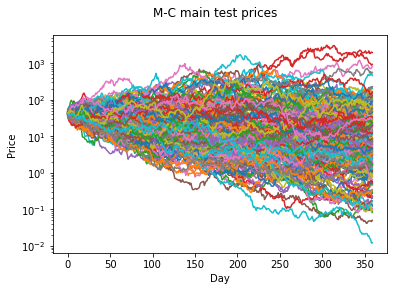

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]
print(Output_params)

print("Average min CF = {:.3f}" .format(list_avg(min_CF)))
print("Average max CF = {:.3f}" .format(list_avg(max_CF)))

print("Average Overcollateralization factor for all simulations = {:.3f}" .format(np.average(avg_Overcollateralization)))
print("Average min level of Overcollateralization = {:.3f}" .format(np.average(min_level_Overcollateralization)))

# print("Average succesful Health factor rate = {:.1f}%".format(100*O.shape[1]/NumOfSimulation))

fig = plt.figure()
fig.suptitle("M-C main test prices")
plt.plot(df)
plt.xlabel('Day')
plt.ylabel('Price')
plt.yscale("log")
plt.show()    

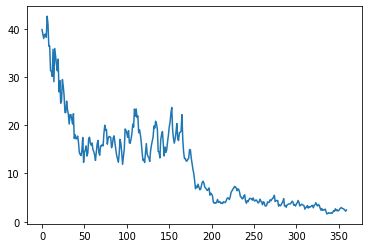

In [12]:
# Results

plt.plot(price_list)

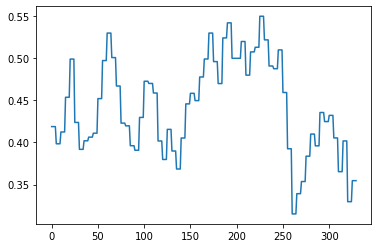

In [11]:
plt.plot(final_CF)